# Compare the amplitude with the KdV solution

In [2]:
from soda.dataio import netcdfio
from soda.dataio.conversion import readotps
from soda.utils.othertime import SecondsSince

from datetime import datetime
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import h5py
import seaborn as sns


In [3]:
%matplotlib notebook

In [22]:
# Load the KdV solution
# dskdv = xr.open_dataset('../output/2019-11-12--00-42-28_slim-harmonic_beta_pred_a0_magnus_kdv_runs.nc')
# betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_201605_201705_prediction.h5'
# a0file = '../inputs/a0_samples_harmonicfit_M2S2nonstat_N2K1O1_12month.h5'
# sitename = 'harmonic_beta_a0_20162017'

dskdv = xr.open_dataset('../output/2019-11-28--00-52-03_slim-fblock-20072009_magnus_kdv_runs.nc')
betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_200709_200910_prediction.h5'
a0file = '../inputs/a0_samples_harmonicfit_FBlock_20072009.h5'
sitename = 'fblock_20072009'

# dskdv = xr.open_dataset('../output/2019-11-27--00-32-41_slim-harmonic_beta_band3_a0_magnus_kdv_runs.nc')
# betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_201605_201705_prediction.h5'
# a0file = '../inputs/a0_samples_bandpass_3h_12month.h5'
# sitename = 'harmonic_beta_a0_bandpass_3h'

# dskdv = xr.open_dataset('../output/2019-11-27--00-34-06_slim-harmonic_beta_band6_a0_magnus_kdv_runs.nc')
# betafile = '../inputs/ShellCrux_Filtered_Density_Harmonic_MCMC_201605_201705_prediction.h5'
# a0file = '../inputs/a0_samples_bandpass_6h_12month.h5'
# sitename = 'harmonic_beta_a0_bandpass_6h'


# # Create a time series of single days with the max amplitude 
# time1 = pd.date_range('2016-5-1','2016-9-15',freq='12.5H') 
# time2 = pd.date_range('2016-11-1','2017-5-1',freq='12.5H')
# timemax = time1.append(time2)
timemax = pd.date_range('2007-9-3','2009-10-01',freq='12.5H') 
# dskdv = dskdv.sel(time=range(0,367))



In [23]:
badidx = dskdv.amax==-999.
dskdv.amax.values[badidx] = np.nan
dskdv.ubed.values[badidx] = np.nan
dskdv.a0.values[badidx] = np.nan
dskdv.cn_mu.values[badidx] = np.nan
dskdv.alpha_mu.values[badidx] = np.nan
dskdv.cn.values[badidx] = np.nan
dskdv.alpha.values[badidx] = np.nan

# dskdv.where(dskdv.amax!=-999)

In [24]:
# Get the time from the input beta file

timedays = dskdv.time
nt = timedays.shape[0]

# Get the time from the beta file
with h5py.File(betafile,'r') as f:
    t=f['data/time'][:].astype('<M8[ns]')
time = t[:nt] +  np.timedelta64(1,'D')


time.shape, t.shape, nt

((1127,), (1127,), 1127)

In [25]:
# Load the a0 data
with h5py.File(a0file,'r') as f:
    print([ff for ff in f['data'].keys()])
    ta0=f['data/dtime64'][:].astype('<M8[ns]')
    a0_samples = f['data/a0-all-times-samples'][:]

time[0], ta0[0], a0_samples.shape

['a0-all-times-samples', 'dtime64', 'time']


(numpy.datetime64('2007-09-02T00:00:00.000000000'),
 numpy.datetime64('2007-09-01T00:00:00.000000000'),
 (1127, 500))

In [26]:
# update the time
dskdv['time'] = time
#dskdv['time'] = dskdv['time'].astype('<M8[ns]')
#dskdv['time']
dskdv

<xarray.Dataset>
Dimensions:    (ensemble: 500, params: 6, time: 1127)
Coordinates:
  * time       (time) datetime64[ns] 2007-09-02 2007-09-03 ... 2010-10-02
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params     (params) int64 0 1 2 3 4 5
Data variables:
    amax       (ensemble, time) float64 -14.83 -14.35 -15.5 ... -14.53 0.0
    tmax       (ensemble, time) float64 ...
    a0         (ensemble, time) float64 12.69 12.6 13.17 13.0 ... 14.53 12.3 0.0
    cn         (ensemble, time) float64 1.159 1.227 1.216 ... 1.166 1.193 0.0
    alpha      (ensemble, time) float64 -0.0002859 -0.002778 ... -0.0007387 0.0
    alpha2     (ensemble, time) float64 ...
    cn_mu      (ensemble, time) float64 1.438 1.49 1.515 ... 1.453 1.465 0.0
    alpha_mu   (ensemble, time) float64 -0.005024 -0.00694 ... -0.005533 0.0
    alpha2_mu  (ensemble, time) float64 ...
    beta       (time, ensemble, params) float64 ...
    ubed       (ensemble, time) float64 0.1841 0.216

<IPython.core.display.Javascript object>


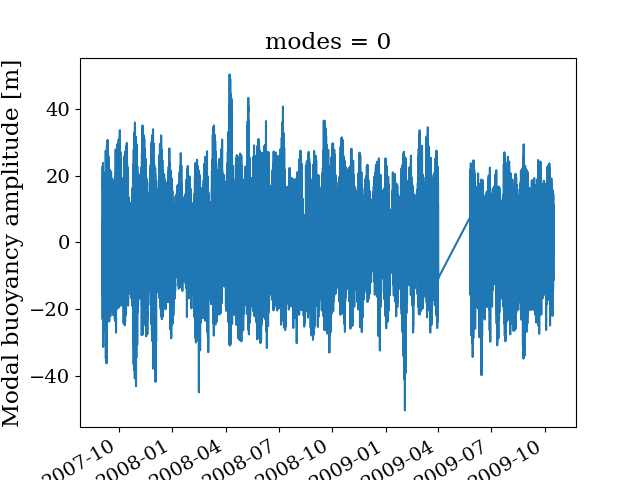

In [27]:
# Load the observed amplitude and stratification data
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/Prelude_Fitted_Buoyancy.nc'
mode = 0
###########


# Merge the two
# with Dataset(ncfile) as nc:
#     for gg in nc.groups.keys():
#         print(gg)
    
ds0 = xr.open_dataset(ncfile,group='F_Block_2007_CM04')
ds1 = xr.open_dataset(ncfile,group='F_Block_2008a_CM04')
ds2 = xr.open_dataset(ncfile,group='F_Block_2008b_CM04')
ds3 = xr.open_dataset(ncfile,group='F_Block_2009a_CM04')
ds4 = xr.open_dataset(ncfile,group='F_Block_2009b_CM04')



A_n = xr.concat([ds0['A_n'][:,mode],
    ds1['A_n'][:,mode],ds2['A_n'][:,mode],\
                ds3['A_n'][:,mode],ds4['A_n'][:,mode]], dim='time')

# a0 = xr.concat([ds0['amp'][:,0,0],
#     ds1['amp'][:,0,0],ds2['amp'][:,0,0],\
#                 ds3['amp'][:,0,0],ds4['amp'][:,0,0]], dim='timeslow')

# c_n = xr.concat([ds0['cn'][:,mode],
#     ds1['cn'][:,mode],ds2['cn'][:,mode],\
#                 ds3['cn'][:,mode],ds4['cn'][:,mode]], dim='timeslow')

# r10_n = xr.concat([ds0['r10'][:,mode],
#     ds1['r10'][:,mode],ds2['r10'][:,mode],\
#                 ds3['r10'][:,mode],ds4['r10'][:,mode]], dim='timeslow')

# alpha_n = -2*c_n*r10_n
# #a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')



# # Create a time series of single days with the max amplitude 
# #time1 = pd.date_range('2016-5-1','2016-9-15') 
# #time2 = pd.date_range('2016-11-1','2017-5-1')
# #time = time1.append(time2)

# time = pd.date_range('2007-09-1','2009-10-1') 

# plt.figure()
# A_n.plot(lw=0.2)
# a0.plot()

plt.figure()
A_n.plot()

In [31]:
def min_amplitude_finder(amp_signal):
    if amp_signal.shape[0] == 0:
        return np.nan,0
    amp_min = np.nanmin(amp_signal)
    return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    
def maximum_amplitude_finder(amp_signal):
    amp_min = np.nanmin(amp_signal)
    amp_max = np.nanmax(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

<IPython.core.display.Javascript object>


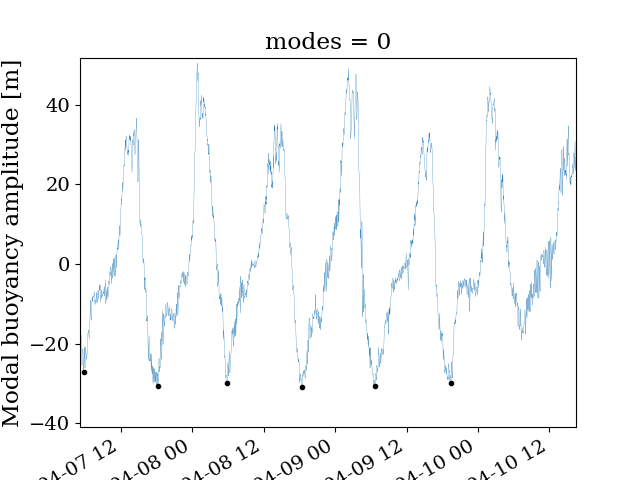

In [33]:
# Find the A_max over one day blocks


Amax_all = []
Amax_time = []
for t1,t2 in zip(timemax[0:-1],timemax[1::]):
    #t2 = t1 + np.timedelta64(1,'D')
    
    #Amax, tidx = maximum_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    Amax, tidx = min_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    if np.isnan(Amax):
        tmax = t1
    else:
        tmax = A_n.sel(time=slice(t1,t2)).time[tidx].values
    Amax_all.append(Amax)
    Amax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_A = xr.DataArray(Amax_all, coords={'time':Amax_time}, dims=('time',))

plt.figure()
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'k.')

<IPython.core.display.Javascript object>


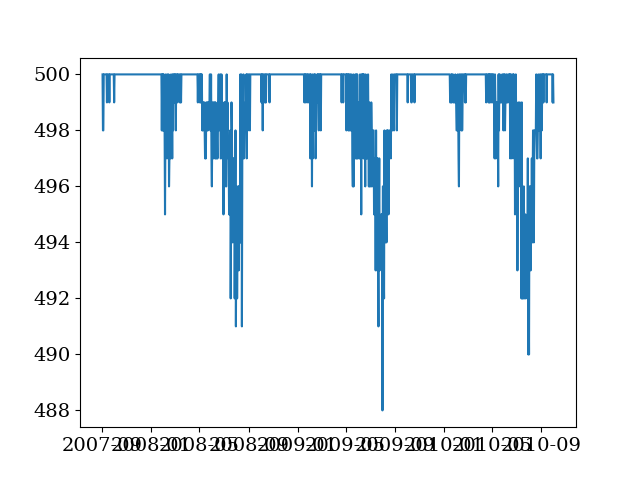

In [34]:
# plot the number of samples
nans = ~np.isnan(dskdv.amax)
N = np.sum(nans,axis=0)
plt.figure()
plt.plot(time,N)

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


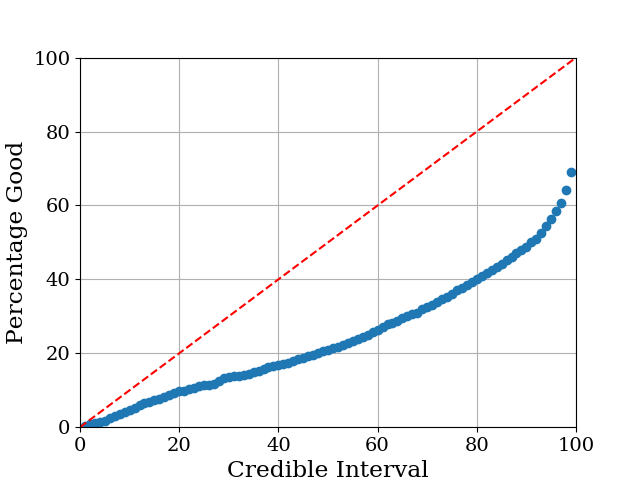

In [39]:
# Count the number of points within each credible interval

# Interplate p95 and p5 onto the observation points

def calc_credint(credint, returnminmax=False):

    lowval = (100-credint)/2
    highval = 100-(100-credint)/2 

    amax_min = np.nanpercentile(dskdv.amax,lowval, axis=0)
    amax_max = np.nanpercentile(dskdv.amax,highval, axis=0)

    tsec = SecondsSince(time)
    tsec_i = SecondsSince(ds_A['time'].values)

    Fmax = interp1d(tsec, amax_max, bounds_error=False)
    Fmin = interp1d(tsec, amax_min, bounds_error=False)

    amax_min_i = Fmin(tsec_i)
    amax_max_i = Fmax(tsec_i)

    idx_in = (ds_A.values > amax_min_i) & (ds_A.values < amax_max_i)

    nt = tsec_i.shape[0]
    #, lowval, highval
    if returnminmax:
        return np.sum(idx_in)/nt * 100,amax_min_i,amax_max_i

    else:
        return np.sum(idx_in)/nt * 100

credint = range(1,100)
perc_in = [calc_credint(ii) for ii in credint]

plt.figure()
plt.plot(credint, perc_in,'o')
plt.plot([0,100],[0,100],'r--')
plt.ylim(0,100)
plt.xlim(0,100)
plt.ylabel('Percentage Good')
plt.xlabel('Credible Interval')
plt.grid(b=True)

In [54]:
# Count the number of large amplitude wave events within the credible interval
bigwave_thresh = -40
idx = ds_A.values < bigwave_thresh
nlarge = np.sum(idx)

_, amax_min_i, amax_max_i = calc_credint(95, returnminmax=True)

idx_in = (ds_A.values[idx] > amax_min_i[idx]) & (ds_A.values[idx] < amax_max_i[idx])

np.sum(idx_in), nlarge

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


(1, 6)

# Count:
 
 - Number of times obs exceeds the threshold
 - Number of times obs and model exceed 40 m together
 - Number of times model exceeds 40 m but obs. does not
 - Number of times obs. exceeds 40 m but models does not

<IPython.core.display.Javascript object>


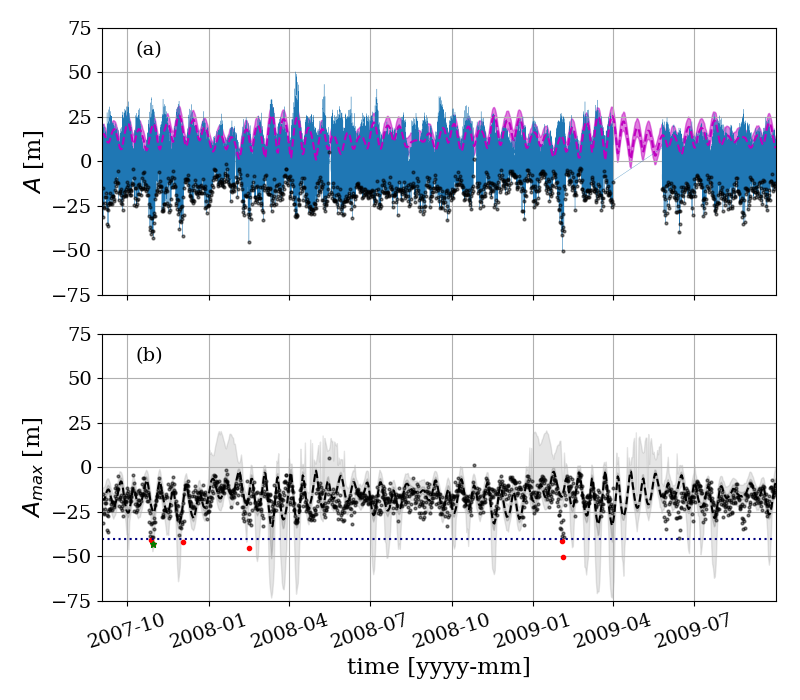

In [55]:
amax_min = np.nanpercentile(dskdv.amax,2.5, axis=0)
amax_max = np.nanpercentile(dskdv.amax,97.5, axis=0)
amax_low = np.nanpercentile(dskdv.amax,25, axis=0)
amax_high = np.nanpercentile(dskdv.amax,75, axis=0)
# amax_amin = np.min(dskdv.amax, axis=0)
# amax_amax = np.max(dskdv.amax, axis=0)
amax_50 = np.nanmedian(dskdv.amax, axis=0)

xlim = [timemax[0],timemax[-1]]
plt.figure(figsize=(8,7))

ax1=plt.subplot2grid((4,1),(0,0),rowspan=2)
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)
plt.plot(ta0, a0_samples.mean(axis=1),'m--')
plt.fill_between(ta0, np.percentile(a0_samples,2.5,axis=1),
         np.percentile(a0_samples,97.5,axis=1), color='m',alpha=0.5    )

ax1.set_xticklabels([])
plt.xlabel('')
plt.grid(b=True)
plt.ylabel('$A$ [m]')
plt.ylim(-75,75)
plt.title('')
plt.xlim(xlim)
plt.text(0.05,0.9,'(a)',transform=ax1.transAxes)
ax1.set_xticklabels([])

ax2=plt.subplot2grid((4,1),(2,0),rowspan=2,)
plt.fill_between(time, amax_min, amax_max, color='0.5',alpha=0.2)
# plt.fill_between(time, amax_min, amax_max, color='0.3',alpha=0.2)
plt.fill_between(time, amax_low, amax_high, color='0.3',alpha=0.2)

plt.plot(time,amax_50,'k--', lw=1.5)
#plt.plot(time, uamp_mapped, 'ko', ms=2,alpha=0.5)
plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)

plt.plot(ds_A['time'][idx], ds_A.values[idx],'ro', ms=3,)
plt.plot(ds_A['time'][idx][idx_in], ds_A.values[idx][idx_in],'g*', ms=5, )

plt.plot([ds_A['time'].values[0],ds_A['time'].values[-1]],[bigwave_thresh,bigwave_thresh],'navy',ls=':')
# plot the good and bad predictions


# plt.plot(time, a0_samples.mean(axis=1),'m--')
# plt.fill_between(time, np.percentile(a0_samples,2.5,axis=1),
#          np.percentile(a0_samples,97.5,axis=1), color='m',alpha=0.5    )

#plt.xlim(200,300)
plt.ylabel('$A_{max}$ [m]')
plt.ylim(-75,75)
#plt.xlabel('time [days]')
plt.grid(b=True)
#plt.plot([time[0],time[-1]],[-0.5,-0.5],'r--',lw=2.)
plt.xlim(xlim)
plt.xlabel('time [yyyy-mm]')
plt.grid(b=True)

plt.xticks(rotation=17)
plt.text(0.05,0.9,'(b)',transform=ax2.transAxes)

plt.tight_layout()
plt.show()
plt.savefig('../FIGURES/kdv_12month_Amax_validation_{}.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/kdv_12month_Amax_validation_{}.pdf'.format(sitename),dpi=150)

<IPython.core.display.Javascript object>


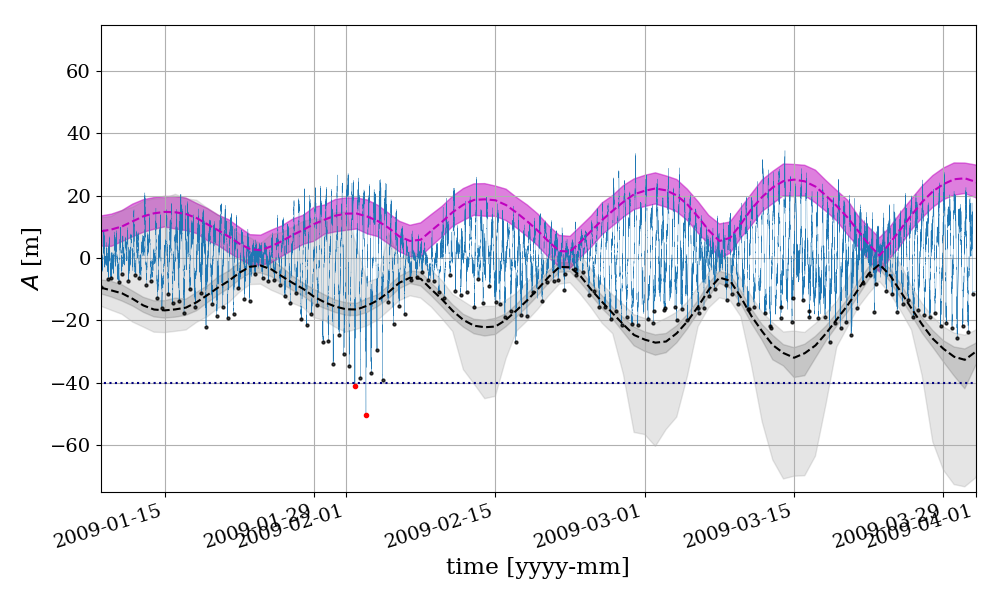

In [43]:
xlim = [datetime(2009,1,9),datetime(2009,4,1)]
plt.figure(figsize=(10,6))

# ax1=plt.subplot2grid((4,1),(0,0),rowspan=2)
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)

plt.plot(ta0, a0_samples.mean(axis=1),'m--')
plt.fill_between(ta0, np.percentile(a0_samples,2.5,axis=1),
         np.percentile(a0_samples,97.5,axis=1), color='m',alpha=0.5    )

# ax1.set_xticklabels([])
# plt.xlabel('')
# plt.grid(b=True)
# plt.ylabel('$A$ [m]')
# plt.ylim(-75,75)
# plt.title('')
# plt.xlim(xlim)
# plt.text(0.05,0.9,'(a)',transform=ax1.transAxes)


# ax2=plt.subplot2grid((4,1),(2,0),rowspan=2)
# plt.fill_between(time, amax_amin, amax_amax, color='0.5',alpha=0.2)
plt.fill_between(time, amax_min, amax_max, color='0.5',alpha=0.2)
plt.fill_between(time, amax_low, amax_high, color='0.3',alpha=0.2)

plt.plot(time,amax_50,'k--', lw=1.5)
#plt.plot(time, uamp_mapped, 'ko', ms=2,alpha=0.5)
plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)

plt.plot(ds_A['time'][idx], ds_A.values[idx],'ro', ms=3,)
plt.plot(ds_A['time'][idx][idx_in], ds_A.values[idx][idx_in],'g*', ms=5, )

plt.plot([ds_A['time'].values[0],ds_A['time'].values[-1]],[bigwave_thresh,bigwave_thresh],'navy',ls=':')

# plt.legend(('$A(t)$','$A_{max}$','$a_0(t)$ - median','$A_{max}$ - median','$A_{max}$ - 95%'
#            ))
#plt.xlim(200,300)
plt.ylabel('$A$ [m]')
plt.ylim(-75,75)
#plt.xlabel('time [days]')
plt.grid(b=True)
#plt.plot([time[0],time[-1]],[-0.5,-0.5],'r--',lw=2.)
plt.xlim(xlim)
plt.xlabel('time [yyyy-mm]')
plt.grid(b=True)
#plt.xlim(time[0],time[-1])
plt.xticks(rotation=17)
# plt.text(0.05,0.9,'(b)',transform=ax2.transAxes)
plt.title('')
plt.tight_layout()
plt.show()
plt.savefig('../FIGURES/kdv_12month_Amax_validation_zoom_{}.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/kdv_12month_Amax_validation_zoom_{}.pdf'.format(sitename),dpi=150)

<IPython.core.display.Javascript object>


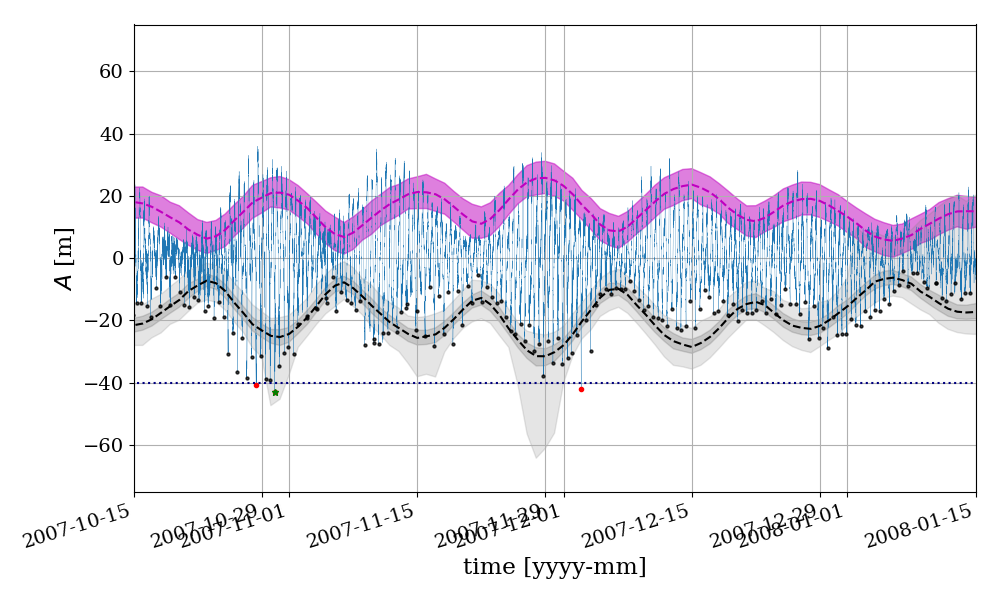

In [44]:
xlim = [datetime(2007,10,15),datetime(2008,1,15)]
plt.figure(figsize=(10,6))

# ax1=plt.subplot2grid((4,1),(0,0),rowspan=2)
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)

plt.plot(ta0, a0_samples.mean(axis=1),'m--')
plt.fill_between(ta0, np.percentile(a0_samples,2.5,axis=1),
         np.percentile(a0_samples,97.5,axis=1), color='m',alpha=0.5    )

# ax1.set_xticklabels([])
# plt.xlabel('')
# plt.grid(b=True)
# plt.ylabel('$A$ [m]')
# plt.ylim(-75,75)
# plt.title('')
# plt.xlim(xlim)
# plt.text(0.05,0.9,'(a)',transform=ax1.transAxes)


# ax2=plt.subplot2grid((4,1),(2,0),rowspan=2)
# plt.fill_between(time, amax_amin, amax_amax, color='0.5',alpha=0.2)
plt.fill_between(time, amax_min, amax_max, color='0.5',alpha=0.2)
plt.fill_between(time, amax_low, amax_high, color='0.3',alpha=0.2)

plt.plot(time,amax_50,'k--', lw=1.5)
#plt.plot(time, uamp_mapped, 'ko', ms=2,alpha=0.5)
plt.plot(ds_A['time'], ds_A.values,'ko', ms=2, alpha=0.5)

plt.plot(ds_A['time'][idx], ds_A.values[idx],'ro', ms=3,)
plt.plot(ds_A['time'][idx][idx_in], ds_A.values[idx][idx_in],'g*', ms=5, )

plt.plot([ds_A['time'].values[0],ds_A['time'].values[-1]],[bigwave_thresh,bigwave_thresh],'navy',ls=':')

# plt.legend(('$A(t)$','$A_{max}$','$a_0(t)$ - median','$A_{max}$ - median','$A_{max}$ - 95%'
#            ))
#plt.xlim(200,300)
plt.ylabel('$A$ [m]')
plt.ylim(-75,75)
#plt.xlabel('time [days]')
plt.grid(b=True)
#plt.plot([time[0],time[-1]],[-0.5,-0.5],'r--',lw=2.)
plt.xlim(xlim)
plt.xlabel('time [yyyy-mm]')
plt.grid(b=True)
#plt.xlim(time[0],time[-1])
plt.xticks(rotation=17)
# plt.text(0.05,0.9,'(b)',transform=ax2.transAxes)
plt.title('')
plt.tight_layout()
plt.show()
plt.savefig('../FIGURES/kdv_12month_Amax_validation_zoom2_{}.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/kdv_12month_Amax_validation_zoom2_{}.pdf'.format(sitename),dpi=150)

<IPython.core.display.Javascript object>


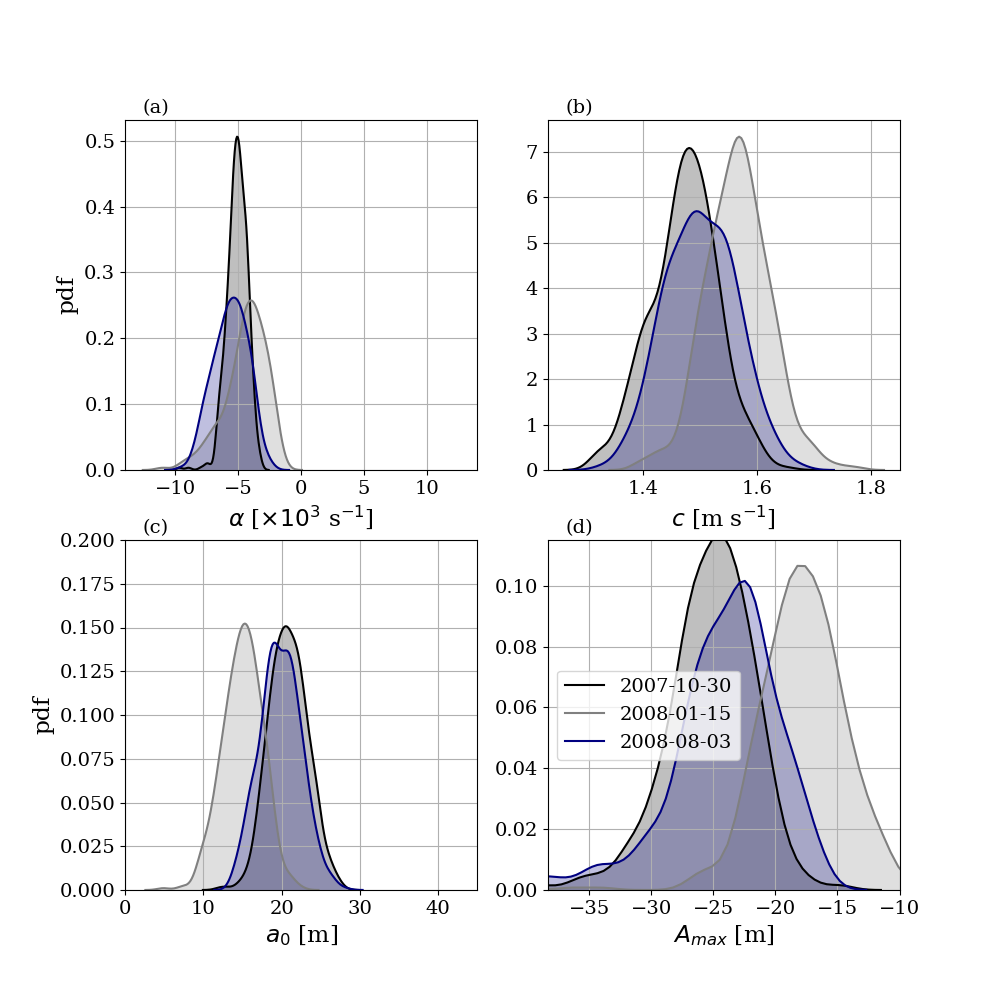

In [48]:
# Locate the time index
t1new = '2007-10-30'
t2new = '2008-01-15'
t3new = '2008-08-03'



ds_A_t1 = dskdv.sel(time=np.datetime64(t1new,'ns'), method='nearest')
ds_A_t2 = dskdv.sel(time=np.datetime64(t2new,'ns'), method='nearest')
ds_A_t3 = dskdv.sel(time=np.datetime64(t3new,'ns'), method='nearest')


plt.figure(figsize=(10,10))
ax=plt.subplot(221)
sns.kdeplot(ds_A_t1.alpha_mu*1e3, color='k',shade=True, legend=False, ls='-')
sns.kdeplot(ds_A_t2.alpha_mu*1e3, color='0.5',shade=True, legend=False, ls='-')
sns.kdeplot(ds_A_t3.alpha_mu*1e3, color='navy',shade=True, legend=False, ls='-')


# sns.kdeplot(ds_A_t1.alpha*1e3, color='k',shade=True, legend=False)
# sns.kdeplot(ds_A_t2.alpha*1e3, color='0.5',shade=True, legend=False)


plt.ylabel('pdf')
#plt.legend(('mean %s'%t1new,'mean %s'%t2new,t1new,t2new))
# plt.legend((t1new,t2new))

plt.xlabel(r'$\alpha$ [$\times 10^3$ s$^{-1}$]')
plt.xlim(-14,14)
plt.grid(b=True)
ax.text(0.05,1.02, '(a)', transform=ax.transAxes)


ax=plt.subplot(222)

# sns.kdeplot(ds_A_t1.cn, color='k',shade=True, legend=False)
# sns.kdeplot(ds_A_t2.cn, color='0.5',shade=True, legend=False)

sns.kdeplot(ds_A_t1.cn_mu, color='k',shade=True, legend=False, ls='-')
sns.kdeplot(ds_A_t2.cn_mu, color='0.5',shade=True, legend=False, ls='-')
sns.kdeplot(ds_A_t3.cn_mu, color='navy',shade=True, legend=False, ls='-')

plt.xlabel('$c$ [m s$^{-1}$]')
plt.grid(b=True)
ax.text(0.05,1.02, '(b)', transform=ax.transAxes)


ax=plt.subplot(223)
plt.ylabel('pdf')

sns.kdeplot(ds_A_t1.a0, color='k',shade=True, legend=False)
sns.kdeplot(ds_A_t2.a0, color='0.5',shade=True, legend=False)
sns.kdeplot(ds_A_t3.a0, color='navy',shade=True, legend=False)

plt.xlim(0,45)
plt.xlabel('$a_0$ [m]')
plt.grid(b=True)
ax.text(0.05,1.02, '(c)', transform=ax.transAxes)
ax.set_ylim(0,0.20)

ax=plt.subplot(224)

sns.kdeplot(ds_A_t1.amax, color='k',shade=True, legend=False)
sns.kdeplot(ds_A_t2.amax, color='0.5',shade=True, legend=False)
sns.kdeplot(ds_A_t3.amax, color='navy',shade=True, legend=False)

plt.xlim(-100,30)
plt.xlabel('$A_{max}$ [m]')
ax.text(0.05,1.02, '(d)', transform=ax.transAxes)
plt.grid(b=True)
#ax.set_yscale('log')
ax.set_ylim(0,0.15)
plt.legend((t1new,t2new,t3new))


plt.savefig('../FIGURES/vkdv_posteriordist_%s.png'%t1new, dpi=150)
plt.savefig('../FIGURES/vkdv_posteriordist_%s.pdf'%t1new, dpi=300)